## Предобработка: 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
answers = pd.read_excel("/content/drive/My Drive/answers_base.xlsx")
questions = pd.read_excel("/content/drive/My Drive/queries_base.xlsx")
train, test1 = train_test_split(questions, test_size=0.3)

In [ ]:
ans = pd.concat([pd.Series(row['Номер связки'], row["Текст вопросов"].split('\n'))              
                    for _, row in answers.iterrows()]).reset_index()
new = pd.DataFrame([train['Номер связки\n'], train["Текст вопроса"]]).transpose()
new = new.rename(columns = {'Номер связки\n': 'i', "Текст вопроса": 'k'}, inplace = False)
ans = ans.rename(columns = {0: 'i', "index": 'k'}, inplace = False)
train = new.append(ans, ignore_index = True)

In [ ]:
train = train.dropna().reset_index()
test1 = test1.dropna(thresh=3).reset_index()

In [ ]:
test1

,index,Текст вопроса,Номер связки\n,Тематика,Unnamed: 3,Unnamed: 4
0,2028,Савина Галина Ивановна брали мазок 29.08 резул...,6.0,ТЕСТИРОВАНИЕ (АНАЛИЗ) НА КОРОНАВИРУС\n,NaN,NaN
1,1625,"Скажите пожалуйста, приезжих из других регионо...",37.0,"ОГРАНИЧЕНИЯ, ПРОПУСКНАЯ СИСТЕМА И ПЕРЕМЕЩЕНИЕ ...",NaN,NaN
2,1080,Здравствуйте!\nМоя родственница находится на л...,257.0,"ОКАЗАНИЕ МЕДИЦИНСКОЙ ПОМОЩИ, ГОТОВНОСТЬ СТАЦИО...",NaN,NaN
3,275,"Добрый день, подскажите пожалуйста. Если иност...",308.0,"ЗАКРЫТИЕ ГРАНИЦ, ОТКРЫТИЕ ГРАНИЦ РОССИИ И АВИА...",NaN,NaN
4,799,Здравствуйте.\nПрилетел из Стамбула в Санкт-Пе...,308.0,"ЗАКРЫТИЕ ГРАНИЦ, ОТКРЫТИЕ ГРАНИЦ РОССИИ И АВИА...",NaN,NaN
...,...,...,...,...,...,...
683,1290,Здравствуйте! У меня следующие симптомы: темпе...,79.0,О КОРОНАВИРУСЕ И СИМПТОМАХ,NaN,NaN
684,1054,Добрый день!Хотелось бы выяснить какой сейчас ...,257.0,"ОКАЗАНИЕ МЕДИЦИНСКОЙ ПОМОЩИ, ГОТОВНОСТЬ СТАЦИО...",NaN,NaN
685,935,"Прилетел сегодня из Турции, результаты теста н...",308.0,"\nЗАКРЫТИЕ ГРАНИЦ, ОТКРЫТИЕ ГРАНИЦ РОССИИ И АВ...",NaN,NaN
686,809,"Здравствуйте. Извините за беспокойство, но нуж...",308.0,"ЗАКРЫТИЕ ГРАНИЦ, ОТКРЫТИЕ ГРАНИЦ РОССИИ И АВИА...",NaN,NaN


In [ ]:
c = train.index
y_train = train["i"].to_numpy()

In [ ]:
import nltk
nltk.download("stopwords")

In [ ]:
!pip install pymorphy2

In [ ]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))
# функция препроцессинга
def preprocess(rawtext):
    ans = ''
    for char in rawtext:
        if char.isalpha() or char == ' ':
            ans += char
        else:
            ans += ' '
    words = ans.split(" ")
    w = []
    for i in words:
        if i != '':
            p = morph.parse(i.lower())[0].normal_form
            if p not in stop_words:
                w.append(p)
    return " ".join(w)

morph = MorphAnalyzer()

In [ ]:
train['proc'] = train['k'].apply(lambda x: preprocess(x))
test1['proc'] = test1['Текст вопроса'].apply(lambda x: preprocess(x))

In [ ]:
test = pd.DataFrame([test1['Номер связки\n'], test1['proc']]).transpose().reset_index()

In [ ]:
x_test = test['proc']
x_train = train['proc']
y_test = test["Номер связки\n"].to_numpy()

### Сделаем простой подход - по близости TF-IDF векторов:


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vectorizer_old = TfidfVectorizer()
OLD = vectorizer_old.fit_transform(x_train)
OLD.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def q_to_vec(text):
    ar = []
    ar.append(text)
    vec = vectorizer_old.transform(ar).toarray()
    return vec[0]

In [ ]:
simple_answers = []
for i, r in enumerate(x_test):
    try:
        total = OLD.dot(q_to_vec(r))

        s = {}
        for i, text in enumerate(total):
            s[c[i]] = text

        res = sorted(s.items(), key=lambda x: x[1], reverse=True)
        simple_answers.append(y_train[res[0][0]])
    except:
        simple_answers.append(0)

In [ ]:
num_correct = sum(p == t for p, t in zip(y_test, np.array(simple_answers)))

In [ ]:
num_correct/len(y_test)

0.5261627906976745

##Попробуем улучшить подход - что, если подойти к решению как к мульти-лейбл классификации? Загрузим полученные TF-IDF в логистическую регрессию

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [ ]:
clf = LogisticRegression().fit(OLD, y_train)

In [ ]:
X_test = vectorizer_old.transform(x_test)

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import *
acc = accuracy_score(y_test, predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.6599


##А если заменить tf-idf на count vectorizer?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv=CountVectorizer()
cv_train=cv.fit_transform(x_train)
print(cv_train.shape)

(2383, 5865)


In [ ]:
X_test = cv.transform(x_test)

In [ ]:
X_test

<688x5865 sparse matrix of type '<class 'numpy.int64'>'
	with 18987 stored elements in Compressed Sparse Row format>

In [ ]:
clf = LogisticRegression(max_iter=1000).fit(cv_train, y_train)

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.6788


###Биграммы, другие n граммы только ухудшают качество:

In [ ]:
cv=CountVectorizer(ngram_range=(1,2))
cv_train=cv.fit_transform(x_train)
print(cv_train.shape)

(2383, 42006)


In [ ]:
X_test = cv.transform(x_test)
clf = LogisticRegression(max_iter=1000).fit(cv_train, y_train)
predicted = clf.predict(X_test)
acc = accuracy_score(y_test, predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.6788


In [ ]:
cv=CountVectorizer(ngram_range=(1,3))
cv_train=cv.fit_transform(x_train)
print(cv_train.shape)

(2383, 91068)


In [ ]:
X_test = cv.transform(x_test)
clf = LogisticRegression(max_iter=1000).fit(cv_train, y_train)
predicted = clf.predict(X_test)
acc = accuracy_score(y_test, predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.6773


###хочу потестить другие модели, так как с регрессией ничего лучше уже у меня не получается:

In [ ]:
cv=CountVectorizer()
cv_train=cv.fit_transform(x_train)
X_test = cv.transform(x_test)

RandomForest:


In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))} 
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(cv_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


In [ ]:
predicted = best_clf.predict(X_test)

In [ ]:
acc = accuracy_score(y_test.astype('int32'), predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.5991


####хочу попробовать еще SGDClassifier

подберем функцию ошибки

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


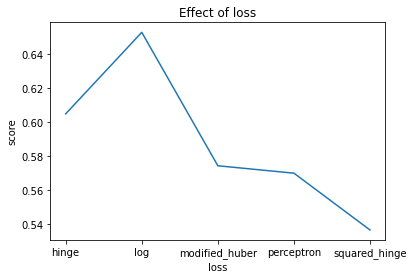

In [ ]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    model = SGDClassifier(loss=loss, max_iter=1000)
    model.fit(cv_train, y_train)
    scores.append(model.score(X_test, y_test))
  
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 


добавлю TfidfTransformer

In [ ]:
sgd = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss= 'log')),
               ])
sgd.fit(cv_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6991279069767442


гридсерч почему-то не помогает..

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "loss" : ["log"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
    "max_iter" : [5,10,50,100,200,500,1000,2000]
}

model = SGDClassifier()
clf = GridSearchCV(model, param_grid=params)

In [ ]:
clf.fit(cv_train, y_train)
print(clf.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.6874249070697461


In [ ]:
clf.best_params_

{'alpha': 0.001, 'loss': 'log', 'max_iter': 50, 'penalty': 'l2'}

In [ ]:
predicted = clf.predict(X_test)
acc = accuracy_score(y_test.astype('int32'), predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.6817


попробую сделать пайплайн сразу с векторайзером:

In [ ]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss= 'log')),
               ])
sgd.fit(x_train, y_train)



y_pred = sgd.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.7020348837209303
